### **Method Review**

- PGD: L-infinity norm restricted attack
	\begin{align}
	x^{t+1}=\Pi_{\epsilon}\{x^t+\alpha\cdot\text{sign}(\nabla_xL(\theta,x,y)),x_0\}
	\end{align}	
    - $x^{t+1}$: the adversarial example generated from step t+1
    - $\epsilon$: epsilon, which controls the perturbation
    - $\Pi_\epsilon$: project the input to the epsilon-ball around $x_0$
    - $\alpha$: step size
    - $\text{sign}(\nabla_xL(\theta,x,y))$: sign of gradient
    - Don't forget to project $x^{t+1}$ to the valid pixel value range. If you don't modify the data loader, the valid pixel value range is $[0,1]$.

- C&W: L-2 norm targeted attack
	\begin{align}
	x^{*}=\arg\min_{x}\|x-x_0\|^2+\lambda\cdot\max\{\max_{j\ne t}f_j(x)-f_t(x),\kappa\}
	\end{align}	
    - $x^{*}$: the adversarial example
    - $\lambda$: parameter that controls the balance between distortion and the attack success. 
    - $f_j(x)$: the logits (predicted score) of class j
    - $t$: the target class
    - $\kappa$: confidence
    - Don't forget to project the $x^{*}$ to $[0,1]$.

- Adversarial training
	\begin{align}
	\arg\min_\theta E_{(x,y)\sim D}\{\max_{\|\delta\|\le\epsilon}L(\theta,x+\delta,y)\}
	\end{align}	
    - $\theta$: model parameters
    - $D$: clean data distribution
    - $\delta$: adversarial perturbation
    - For each batch, generate adversarial examples based on the batch of samples, then update the model with adversarial examples 
    
### **Evaluation Metrics:**

- Testing accuracy: 
	\begin{align}
	\frac{1}{N}\sum_{i=1}^N {\bf 1}(\hat{y}_i=y_i)
	\end{align}	
    - $N$: the total number of samples in the testing set
    - $y_i$: true label of sample $x_i$
    - $\hat{y}_i$: predicted label by the model

- Robust Testing Accuracy: testing accuracy on adversarial examples

	\begin{align}
	\frac{1}{N}\sum_{i=1}^N {\bf 1}(c(x^*_i)=y_i)
	\end{align}	
    - $N$: the total number of samples in the testing set
    - $x^*_i$: adversarial example generated from $x_i$
    - $c(\cdot)$: returns the label predicted by the model
    - $c(x^*_i)$: predicted label of adversarial example by the model
    - $y_i$: true label of sample $x_i$

Implementing **PGD attack** and **targetted C&W attack** on CIFAR10 data set.

**Data.** You will use CIFAR10 classification dataset (10 classes). Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

In [2]:
## The following code can change the working directory to your google drive
## So you don't need to download the data every time

import os
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')


Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch.utils.data as td
import random, time
import matplotlib.pyplot as plt
import torchvision
import PIL.Image as Image
from tqdm import tqdm
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size_cifar = 128

def cifar_loaders(batch_size, shuffle_test=False): 
    data_dir = './data'
    train = datasets.CIFAR10(data_dir, train=True, download=True, 
        transform=transforms.Compose([
            transforms.ToTensor(),
        ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor()]))
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
        shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

train_cifar_loader, test_cifar_loader = cifar_loaders(batch_size_cifar)

# Get the loader that only loads class 0 image (for question 1.d)
def subset_loaders(batch_size=128): 
    data_dir = './data'
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor()]))
    subset_indices = (torch.tensor(test.targets) == 0).nonzero()
    test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size, 
          shuffle=False,sampler=SubsetRandomSampler(subset_indices))
    return test_loader

sub_loader = subset_loaders()

Files already downloaded and verified


In [6]:
## Load the pre-trained VGG11bn model
## For this step, you need to put the vgg.py and vgg11_bn.pt under your working directory
## See vgg.py and vgg11_bn.pt and under the shared google drive folder of HW5 from the course website
## The model is from https://github.com/huyvnphan/PyTorch_CIFAR10
from vgg import vgg11_bn
vgg11 = vgg11_bn()
vgg11.load_state_dict(torch.load('vgg11_bn.pt'))
vgg11.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### **Problem Description.** Generate adversarial examples on CIFAR10 using PGD and C&W.



In [7]:
from tqdm.notebook import tqdm

In [8]:
from __future__ import division
def testClean(test_loader, model):
  model.eval()
  correct_cnt = 0
  total_cnt = 0
  for batch_idx, (x, target) in enumerate(tqdm(test_loader)):
    x = x.to(device)
    target = target.to(device)
    _, predicted = model(x).max(1)
    total_cnt += target.size(0)
    correct_cnt += predicted.eq(target).sum().item()
  acc = float(correct_cnt/total_cnt)
  print('The prediction accuracy is: ')
  return acc

In [9]:
testClean(test_cifar_loader, vgg11)

  0%|          | 0/79 [00:00<?, ?it/s]

The prediction accuracy is: 


0.9239

Implement PGD with L-infinity norm, epsilon=0.03, step size=0.01, max steps=20, to attack the pre-trained VGG11 and generate adversarial examples with the CIFAR10 test set. Report the robust testing accuracy.

In [10]:
# Class that creates perturbed adversarial output
class PGDAttack(object):
    def __init__(self, model=None, epsilon=0.03, steps=20, step_size=0.01):
        self.model = model
        self.epsilon = epsilon
        self.steps = steps
        self.step_size = step_size
        self.cla_loss = nn.CrossEntropyLoss()

    def perturb(self, X_ori, y):
        X = X_ori.clone()
        y_var = y
        for i in range(self.steps):
            X_var = Variable(X, requires_grad=True) 
            outputs = self.model(X_var)
            loss = self.cla_loss(outputs, y_var)
            grad = torch.autograd.grad(loss, X_var,
                                       retain_graph=False, create_graph=False)[0]
            X = X_var.detach() + self.step_size * grad.sign()
            diff = X - X_ori
            diff.clamp_(-self.epsilon, self.epsilon)
            X.detach().copy_((diff + X_ori).clamp_(0, 1))
        return X

In [11]:
def attack_over_test_data(model, adversary, test_loader):
    '''
    Given target model computes accuracy on perturbed data
    '''
    adversary.model = model
    total_correct = 0
    total_samples = len(test_loader.dataset)
    ntested = 0

    pbar = tqdm(test_loader)
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        X_adv = adversary.perturb(X, y)
        y_pred_adv = torch.max(model(X_adv), 1)[1]
        ntested += len(y)
        total_correct += (y_pred_adv == y.data).sum()
        pbar.set_postfix(adv_acc = "{0}/{1} {2:-6.2f}%".format(total_correct, ntested, total_correct*100.0/ntested), refresh=False)
        
    pbar.close()

    acc = total_correct/total_samples
    print(" Got %d/%d correct(%.sf%%) on the perturbed data" % (total_correct, total_samples, 100*acc))
    return acc

In [12]:
adversary = PGDAttack(vgg11, epsilon=0.03, steps=20, step_size=0.01)
robust_acc = attack_over_test_data(vgg11, adversary, test_cifar_loader)  


  0%|          | 0/79 [00:00<?, ?it/s]

 Got 81/10000 correct(f%) on the perturbed data


Answer: 
The robust test accuracy is 0.81%


Plot a batch of adversarial examples (PGD) and the corresponding test samples.

In [11]:
test_iter = iter(test_cifar_loader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)

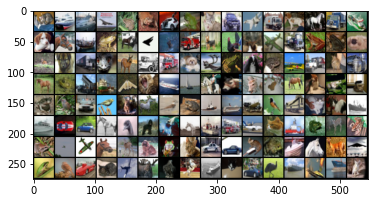

In [13]:
#Plot original images:
ori = torchvision.utils.make_grid(images.cpu(), nrow=16)
plt.imshow(ori.permute(1,2,0))

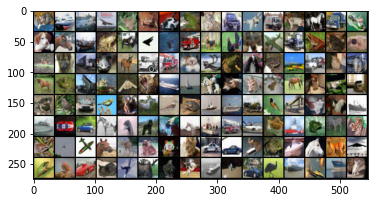

In [14]:
#Plot adversarial images:
adv = torchvision.utils.make_grid(adversary.perturb(images, labels).cpu(), nrow=16)
plt.imshow(adv.permute(1,2,0))

 Implement targeted C&W with L2 norm, lambda=1, confidence=0, max steps=50, using CIFAR10 class 0 test samples. The target class is class 1. Report the testing accuracy on the original class 0 samples, and the proportion of adversarial examples classified as class 1.

In [13]:
#Code:
class CWAttack(object):
    def __init__(self, model=None, confidence=0, steps=50):
        self.model = model
        self.steps = steps
        self.confidence = 0

    def f(self, outputs, target_labels):

        one_hot_labels = torch.eye(len(outputs[0]))[target_labels].to(device)
        # print(one_hot_labels, outputs[:2])
        # i = one_hot_labels
        # j = outputs
        # print(outputs[0].argmax())
        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.byte())
        return torch.clamp(i-j, min=-self.confidence)

    def perturb(self, X_ori, target_labels):
        X = X_ori.clone()
        X_adv = X.clone().zero_().requires_grad_()
        optimizer = optim.Adam([X_adv], lr=1.0e-2)
        for _ in range(self.steps):
            self.model.zero_grad()
            optimizer.zero_grad()
            diff = X_adv - X
            output = self.model(X_adv)
            error = torch.sum(diff*diff)
            error += self.f(output, target_labels).sum()
            error.backward()
            optimizer.step()   
        # X_adv = X_adv.clamp(0,1)   
        return X_adv

In [14]:
def cw_test_target(model, test_loader, target_class):
    model.eval()
    cw = CWAttack(model=model, confidence=0, steps=50)
    correct_cnt = 0
    total_cnt = 0
    for _, (x, labels) in enumerate(tqdm(test_loader)):
        x, labels = x.to(device), labels.to(device)
        target_labels = target_class
        out = model(cw.perturb(x, target_labels))
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        # print(pred_label)
        correct_cnt += (pred_label == target_labels).sum()
    asr = float(correct_cnt.double()/total_cnt)
    print("The proportion of class 0 images classified as class 1 is {}".format(asr))
    return asr

In [15]:
testClean(sub_loader, vgg11)

  0%|          | 0/8 [00:00<?, ?it/s]

The prediction accuracy is: 


0.945

In [29]:
torch.cuda.empty_cache()
cw_asr = cw_test_target(vgg11, sub_loader, target_class=1)

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/IndexKernel.cpp:72.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


The proportion of class 0 images classified as class 1 is 0.933


### Implement **adversarial training** to train VGG11 on CIFAR10.

Implement adversarial training (generate PGD adversarial examples every iteration and train the model with adversarial examples) with PGD (L-infinity norm, epsilon=0.03, step size=0.01, max steps=7). You can initial the model with pre-trained VGG11. Do adversarial training for at least 10 epochs.

In [ ]:
model = vgg11_bn()
model.load_state_dict(torch.load('vgg11_bn.pt'))
model.to(device)

In [17]:
#Code:
def advtrain(model, train_loader):
    model.train()
    adversary = PGDAttack(model, epsilon=0.03, steps=7, step_size=0.01)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        total_loss = 0
        batch_count = 0

        correct_all = 0
        correct_ori_all = 0
        total = 0

        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            m = nn.Softmax()
            x, y = x.to(device), y.to(device)
            outputs = model(x)            
            adv = adversary.perturb(x, y)
            adv_outputs = model(adv)

            loss = criterion((adv_outputs), y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = adv_outputs.max(1)
            _, pred_ori = outputs.max(1)
            total += len(y)
            correct = (predicted == y).float().mean()
            correct_ori = (pred_ori == y).float().mean()
            correct_all += correct
            correct_ori_all += correct_ori
            batch_count += 1
            # print('Epoch [{}/{}], average adv loss {:.4f}, robust accuracy {:.4f}, accuracy {:.4f}'
            #   .format(epoch+1, 10, loss, correct, correct_ori))
            
        epoch_avg_loss = total_loss/batch_count
        acc = correct_all/batch_count
        acc_ori = correct_ori_all/batch_count
        print('Epoch [{}/{}], average adv loss {:.4f}, robust accuracy {:.4f}, accuracy {:.4f}'
                      .format(epoch+1, 10, epoch_avg_loss, acc, acc_ori))

    return model

In [18]:
temp_adv = advtrain(model, train_cifar_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/10], average adv loss 2.0965, robust accuracy 0.2224, accuracy 0.3248


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/10], average adv loss 1.8805, robust accuracy 0.2884, accuracy 0.4425


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/10], average adv loss 1.8011, robust accuracy 0.3204, accuracy 0.4905


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/10], average adv loss 1.7487, robust accuracy 0.3400, accuracy 0.5297


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/10], average adv loss 1.7064, robust accuracy 0.3542, accuracy 0.5542


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/10], average adv loss 1.6741, robust accuracy 0.3676, accuracy 0.5772


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/10], average adv loss 1.6378, robust accuracy 0.3810, accuracy 0.5959


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/10], average adv loss 1.6087, robust accuracy 0.3900, accuracy 0.6123


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/10], average adv loss 1.5839, robust accuracy 0.3984, accuracy 0.6249


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/10], average adv loss 1.5587, robust accuracy 0.4059, accuracy 0.6413


In [19]:
temp_adv = advtrain(model, train_cifar_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/10], average adv loss 1.5345, robust accuracy 0.4164, accuracy 0.6508


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/10], average adv loss 1.5110, robust accuracy 0.4235, accuracy 0.6621


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/10], average adv loss 1.4913, robust accuracy 0.4283, accuracy 0.6735


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/10], average adv loss 1.4698, robust accuracy 0.4356, accuracy 0.6838


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/10], average adv loss 1.4498, robust accuracy 0.4422, accuracy 0.6913


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/10], average adv loss 1.4311, robust accuracy 0.4500, accuracy 0.7030


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/10], average adv loss 1.4113, robust accuracy 0.4554, accuracy 0.7083


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/10], average adv loss 1.3919, robust accuracy 0.4604, accuracy 0.7200


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/10], average adv loss 1.3668, robust accuracy 0.4699, accuracy 0.7278


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/10], average adv loss 1.3471, robust accuracy 0.4775, accuracy 0.7354


### Implement PGD with L-infinity norm, epsilon=0.03, step size=0.01, max steps=20, to attack the **adversarially trained** VGG11 and generate adversarial examples with the CIFAR10 test set. Report the testing accuracy and robust testing accuracy of the **adversarially trained** VGG11 on CIFAR10 test set.

In [24]:
#Code:
testClean(test_cifar_loader, model)

  0%|          | 0/79 [00:00<?, ?it/s]

The prediction accuracy is: 


0.6091

In [23]:

adversary = PGDAttack(temp_adv, epsilon=0.03, steps=20, step_size=0.01)
robust_acc = attack_over_test_data(temp_adv, adversary, test_cifar_loader)

  0%|          | 0/79 [00:00<?, ?it/s]

 Got 3585/10000 correct(f%) on the perturbed data


The performance of the pre-trained VGG11 is not good: the accuracy is around 0.81%. The accurracy of the adversarially trained VGG (after 20 epoches) is much better, which is 35.85%. However, the test accuracy of the original data dropped from 92.23% to 60.91%